<a href="https://colab.research.google.com/github/eikeschuett/IcebergShipDetection/blob/main/test_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download the Kaggle dataset to Google Drive


Following the steps: https://www.kaggle.com/general/74235

In [3]:
! pip install -q kaggle

Go to your account in Kaggle, scroll to API section and click  on "Create New API Token". Then, the file `kaggle.json` will be downloaded into your local drive, upload it with `files.upload()`.

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
% cd /content/drive/MyDrive/

/content/drive/MyDrive


In [20]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"yej117","key":"96f272accceffeb71effc430738d50fd"}'}

Make directory named kaggle and copy `kaggle.json` file there.

In [33]:
! mkdir -p kaggle
! mv kaggle.json kaggle
% cd kaggle/

/content/drive/MyDrive/kaggle


Change the permissions of the file. ((U)ser / owner can read, can write and can't execute. (G)roup and (O)thers have no permission to read, write and execute.)

In [34]:
! chmod 600 kaggle.json

In [35]:
 ! kaggle datasets list

ref                                                            title                                               size  lastUpdated          downloadCount  
-------------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  
arashnic/hr-analytics-job-change-of-data-scientists            HR Analytics: Job Change of Data Scientists        295KB  2020-12-07 00:25:10           1135  
babyoda/access-to-computers-from-home-oecd                     Access to Computers From Home OECD                   3KB  2020-12-04 10:50:09             92  
shashwatwork/impact-of-covid19-pandemic-on-the-global-economy  Impact of Covid-19 Pandemic on the Global Economy    1MB  2020-11-29 14:16:30            553  
emmanuelleai/world-marathons-majors                            World Marathons Majors                               7KB  2020-12-06 19:24:28            113  
mrmorj/dataset-of-songs-in-spotify                  

In [37]:
! mkdir -p data
% cd data
! kaggle competitions download -c statoil-iceberg-classifier-challenge

/content/drive/My Drive/kaggle/data
  0% 0.00/37.7k [00:00<?, ?B/s]
100% 37.7k/37.7k [00:00<00:00, 5.06MB/s]
 68% 29.0M/42.9M [00:00<00:00, 148MB/s]
100% 42.9M/42.9M [00:00<00:00, 142MB/s]
 96% 235M/245M [00:01<00:00, 131MB/s]
100% 245M/245M [00:01<00:00, 131MB/s]


Unzip the *.7z file with the build-in command.

In [38]:
! 7z e test.json.7z 
! 7z e train.json.7z 
! 7z e sample_submission.csv.7z 


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 257127394 bytes (246 MiB)

Extracting archive: test.json.7z
--
Path = test.json.7z
Type = 7z
Physical Size = 257127394
Headers Size = 154
Method = LZMA2:24
Solid = -
Blocks = 1

  0%      0% - data/processed/test.json                                 1% - data/processed/test.json                                 2% - data/processed/test.json                                 3% - data/processed/test.json                                 4% - data/processed/test.json

# Load the dataset

 Mount your Google Drive to the kernel.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import the libraries that required.

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

Some variables:

In [6]:
train_path='/content/drive/MyDrive/kaggle/data/train.json'
test_path='/content/drive/MyDrive/kaggle/data/test.json'

Function for loading training / testing datasets (testing dataset has no label given, which means there's no "is_iceberg" column):

In [8]:
def LoadDataset(data_path):
    df = pd.read_json(data_path)
    #print(df.head(3))
    
    # Change the "na" value in "inc_angle" to NaN
    df["inc_angle"] = df["inc_angle"].replace(["na"], np.nan)

    # Get the labels from training dataset (but not testing dataset)
    if 'is_iceberg' in df.columns:
      labels = np.array(df["is_iceberg"])
    else:
      labels = None

    # Create empty list for the images
    imgs = []
    for i, row in df.iterrows():
        # Reshape list to image
        hh  = np.reshape(row["band_1"], (75, 75))
        hv  = np.reshape(row["band_2"], (75, 75))
        b3  = hh + hv
        
        # Rescale images between 0 and 1 for faster convergence rate
        hh = (hh - hh.min())/(hh.max()-hh.min())
        hv = (hv - hv.min())/(hv.max()-hv.min())
        b3 = (b3 - b3.min())/(b3.max()-b3.min())

        # Stack the bands and append them to imgs
        imgs.append(np.dstack((hh, hv, b3)))

    return imgs, labels


In [9]:
imgs_train, labels_train = LoadDataset(train_path)

# Split dataset into training and validation (dev) datasets
x_train, x_dev, y_train, y_dev = train_test_split(imgs_train, labels_train, test_size=0.2, random_state=0)
x_train = np.array(x_train)
x_dev = np.array(x_dev)

# Set up DataGenerators

Import the library for using data generators

In [10]:
from keras_preprocessing.image import ImageDataGenerator

Image Data Generators for training and validation data

In [11]:
training_datagen = ImageDataGenerator(
    rotation_range = 90,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest')

train_generator = training_datagen.flow(x_train, y_train)


dev_datagen = ImageDataGenerator()

dev_generator = dev_datagen.flow(x_dev, y_dev)

# Define different models

## CNN

import the libraries 

In [12]:
import tensorflow as tf
import keras.optimizers

Check different keras optimizers here: https://keras.io/api/optimizers/

Define the model

In [13]:
def CNN():
    model = tf.keras.models.Sequential([
        # Note the input shape is the desired size of the image 75x75 with 3 bytes color
        # This is the first convolution
        tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(75, 75, 3)),
        tf.keras.layers.MaxPooling2D(3, 3),
        tf.keras.layers.Dropout(0.2),
        # The second convolution
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.2),
        # The third convolution
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.2),
        # The fourth convolution
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.2),
        # Flatten the results to feed into a DNN
        tf.keras.layers.Flatten(),
        # 512 neuron hidden layer
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(128, activation='relu'),
        # Only 1 output neuron. It will contain a value from 0-1 where 0 means ship and 1 means iceberg
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model


# Train with the chosen model

In [14]:
model = CNN()
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(lr=0.001, decay=0.0),
              metrics=['accuracy'])

In [18]:
history = model.fit(
      train_generator,
      #steps_per_epoch=10,  
      epochs=200,
      verbose=1,
      validation_data = dev_generator)#,
      #validation_steps=10)

Epoch 1/200
41/41 [==============================] - 2s 49ms/step - loss: 0.3701 - accuracy: 0.8114 - val_loss: 0.3439 - val_accuracy: 0.8474
Epoch 2/200
41/41 [==============================] - 2s 48ms/step - loss: 0.3557 - accuracy: 0.8184 - val_loss: 0.3890 - val_accuracy: 0.8193
Epoch 3/200
41/41 [==============================] - 2s 47ms/step - loss: 0.3960 - accuracy: 0.8090 - val_loss: 0.3670 - val_accuracy: 0.8224
Epoch 4/200
41/41 [==============================] - 2s 47ms/step - loss: 0.3819 - accuracy: 0.8122 - val_loss: 0.3590 - val_accuracy: 0.8318
Epoch 5/200
41/41 [==============================] - 2s 48ms/step - loss: 0.3800 - accuracy: 0.8192 - val_loss: 0.3448 - val_accuracy: 0.8442
Epoch 6/200
41/41 [==============================] - 2s 48ms/step - loss: 0.3625 - accuracy: 0.8254 - val_loss: 0.3443 - val_accuracy: 0.8474
Epoch 7/200
41/41 [==============================] - 2s 47ms/step - loss: 0.3606 - accuracy: 0.8285 - val_loss: 0.3415 - val_accuracy: 0.8411
Epoch 

Plot the results

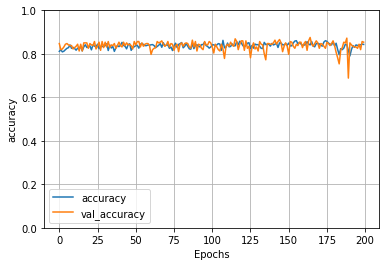

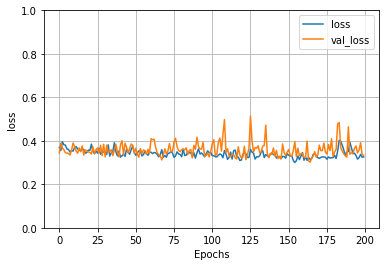

In [19]:
import matplotlib.pyplot as plt
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.ylim([0,1])
    plt.grid()
    plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")